# 1. CNN from scratch

## Import libraries

In [1]:
import os
import cv2
import random
import shutil
import tensorflow as tf
import csv
import pandas as pd
import glob
import keras
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

## Base functions

In [2]:
"""Convert these into floating point tensor and resize them to shared size (256x256). """
def process_data(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (256, 256))

    return img

def compose_dataset(df):
    data= []
    labels = []

    for img_path, label in df.values:
        data.append(process_data(img_path))
        labels.append(label)

    return np.array(data), np.array(labels)

In [3]:
def plot_loss_accurancy(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [4]:
def evaluate_model (model):
    y_score = model.predict(X_val_bal)
    y_pred = np.rint(y_score) # to have 0 or 1
    y_true = y_val_bal
    print("Classification report: ")
    print(metrics.classification_report(y_true,y_pred,digits = 4))
    metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

    # ROC curve
    fpr,tpr,th = metrics.roc_curve(y_true,y_score)
    roc_auc = metrics.roc_auc_score(y_true,y_score)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

## Load the data

In [5]:
dataset_path = "/Users/marysia/Downloads/chest_xray_2"

In [6]:
os.listdir(dataset_path)

['.DS_Store', 'test', 'chest_xray', '__MACOSX', 'train', 'val']

In [7]:
train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')
val_dir = os.path.join(dataset_path, 'val')

train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA/')  # directory with our training Pneumonia pictures
train_normal_dir = os.path.join(train_dir, 'NORMAL/')  # directory with our training Normal pictures
test_pneumonia_dir = os.path.join(test_dir, 'PNEUMONIA/')  # directory with our validation Pneumonia pictures
test_normal_dir = os.path.join(test_dir, 'NORMAL/')  # directory with our validation Normal pictures
val_pneumonia_dir = os.path.join(val_dir, 'PNEUMONIA/')
val_normal_dir = os.path.join(val_dir, 'NORMAL/')

In [8]:
train_normal = os.listdir(train_normal_dir)
train_pneu = os.listdir(train_normal_dir)
test_normal = os.listdir(test_normal_dir)
test_pneu = os.listdir(test_pneumonia_dir)
val_normal = os.listdir(val_normal_dir)
val_pneu = os.listdir(val_pneumonia_dir)

In [9]:
# find all files, our files has extension jpeg
train_norm = glob.glob(train_normal_dir + '*jpeg')
train_pneu = glob.glob(train_pneumonia_dir + '*jpeg')
 
test_norm = glob.glob(test_normal_dir + '*jpeg')
test_pneu = glob.glob(test_pneumonia_dir + '*jpeg')
 
val_norm = glob.glob(val_normal_dir + '*jpeg')
val_pneu = glob.glob(val_pneumonia_dir + '*jpeg')

Count how many pictures we have in each training split (train / validation).

In [10]:
num_pneumonia_tr = len(os.listdir(train_pneumonia_dir))
num_normal_tr = len(os.listdir(train_normal_dir))

num_pneumonia_test = len(os.listdir(test_pneumonia_dir))
num_normal_test = len(os.listdir(test_normal_dir))

num_pneumonia_val = len(os.listdir(val_pneumonia_dir))
num_normal_val = len(os.listdir(val_normal_dir))

total_train = num_pneumonia_tr + num_normal_tr
total_test = num_normal_test + num_normal_test
total_val = num_pneumonia_val + num_normal_val

In [11]:
print('total training pneumonia images:', num_pneumonia_tr)
print('total training normal images:', num_normal_tr)

print('total test pneumonia images:', num_pneumonia_test)
print('total test normal images:', num_normal_test)

print('total validation Pneumonia images:', num_pneumonia_val)
print('total validation normal images:', num_normal_val)
print("--")
print("Total training images:", total_train)
print("Total test images:", total_test)
print("Total validation images:", total_val)

total training pneumonia images: 3875
total training normal images: 1341
total test pneumonia images: 390
total test normal images: 234
total validation Pneumonia images: 8
total validation normal images: 8
--
Total training images: 5216
Total test images: 468
Total validation images: 16


In [78]:
for files_list in [train_norm, train_pneu, test_norm, test_pneu, val_norm, val_pneu]:
    files_list = [x.replace('\\', '/') for x in files_list]
     
print(f'Train: healthy({len(train_norm)}), pneumonia({len(train_pneu)}).\
Healthy as % of total: {100*round(len(train_norm)/(len(train_norm+train_pneu)),2)}%')
print(f'Test: healthy({len(test_norm)}), pneumonia({len(test_pneu)}). \
Healthy as % of total: {100*round(len(test_norm)/(len(test_norm+test_pneu)),2)}%')
print(f'Validation: healthy({len(val_norm)}), pneumonia({len(val_pneu)}). \
Healthy as % of total: {100*round(len(val_norm)/(len(val_norm+val_pneu)),2)}%')

Train: healthy(1341), pneumonia(3875).Healthy as % of total: 26.0%
Test: healthy(234), pneumonia(390). Healthy as % of total: 38.0%
Validation: healthy(8), pneumonia(8). Healthy as % of total: 50.0%


**Con:** Dataset contains 5216 training images, 468 test images and only 16 validation images, so it is  In each split, there is the same number of samples from each class: this is a balanced binary classification problem, which means that classification accuracy will be an appropriate measure of success.

## Visualisation
Show some exaples of data set.

In [13]:
list_total = [] #list with links to all files.
list_total_norm = []
list_total_pneu = []
for x in train_norm + test_norm+ val_norm:
    list_total.append([x, 0])
    list_total_norm.append([x, 0])
    
for x in train_pneu + test_pneu + val_pneu:
    list_total.append([x, 1])
    list_total_pneu.append([x, 0])

I shuffle samples to assurance of random samples.

In [14]:
df_total = pd.DataFrame(list_total, columns=['image', 'label'])
df_total = df_total.sample(frac=1)

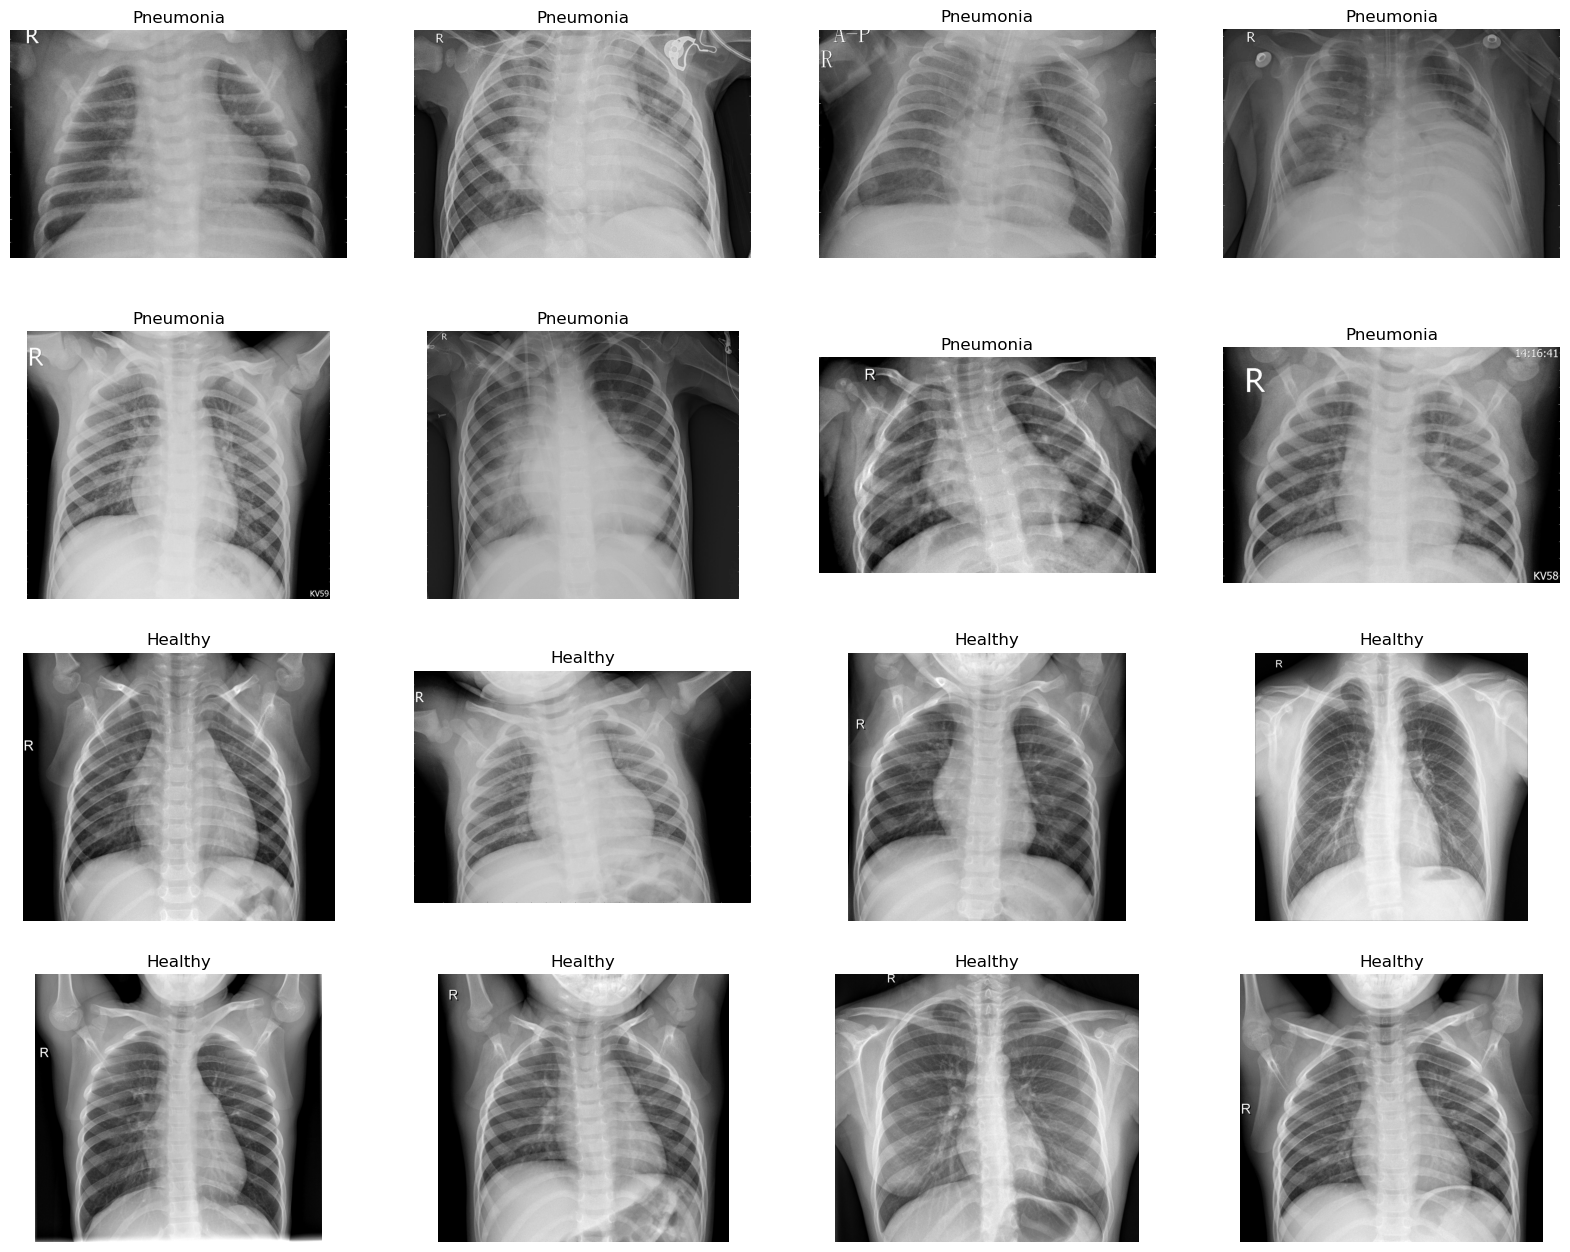

In [15]:
import matplotlib.pyplot as plt
 
plt.figure(figsize=(20,16))
 
for i,img_path in enumerate(df_total[df_total['label'] == 1][0:8]['image']):
    plt.subplot(4,4,i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Pneumonia')

     
for i,img_path in enumerate(df_total[df_total['label'] == 0][0:8]['image']):
    plt.subplot(4,4,8+i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Healthy')


# Data Preparing

Split data to train, test and validation set.

In [18]:
from sklearn.model_selection import train_test_split

train_dataset, test_dataset = train_test_split(df_total, test_size=0.3, random_state=2021)
val_dataset, test_dataset = train_test_split(test_dataset, test_size=0.5, random_state=2021)

In [19]:
X_train, y_train = compose_dataset(train_dataset)
X_test, y_test = compose_dataset(test_dataset)
X_val, y_val = compose_dataset(val_dataset)

In [20]:
print('Train data shape: {}, Labels shape: {}'.format(X_train.shape, y_train.shape))
print('Test data shape: {}, Labels shape: {}'.format(X_test.shape, y_test.shape))
print('Valid data shape: {}, Labels shape: {}'.format(X_val.shape, y_val.shape))

Train data shape: (4099, 256, 256, 3), Labels shape: (4099,)
Test data shape: (879, 256, 256, 3), Labels shape: (879,)
Valid data shape: (878, 256, 256, 3), Labels shape: (878,)


## Split data into train and tests sets
1. Train dataset for train the model
2. Test dataset for premilinary testing
3. Validation dataset for final comparison

## Class balancing
For easier inference from the accuracy metric, the subset sholud be balanced. In order to balance validation set, I took the less numerous class and draw the same amount from the second class.

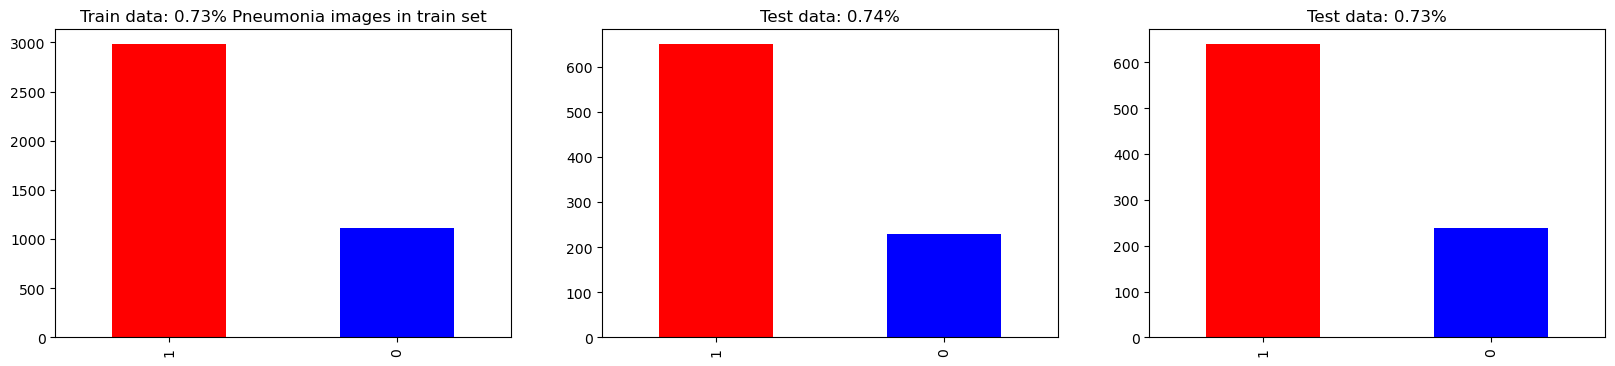

In [81]:
plt.figure(figsize = (20,4 ))

plt.subplot(1, 3, 1)
pd.DataFrame(y_train)[0].value_counts().plot(kind='bar', color=['red','blue'])
plt.title(f"Train data: {round(sum(y_train)/len(y_train), 2)}% Pneumonia images in train set")

plt.subplot(1, 3, 2)
pd.DataFrame(y_test)[0].value_counts().plot(kind='bar', color = ['red', 'blue'])
plt.title(f"Test data: {round(sum(y_test)/len(y_test), 2)}%")

plt.subplot(1, 3, 3)
pd.DataFrame(y_val)[0].value_counts().plot(kind = 'bar', color = ['red', 'blue'])
plt.title(f"Test data: {round(sum(y_val)/len(y_val), 2)}%")

plt.show()

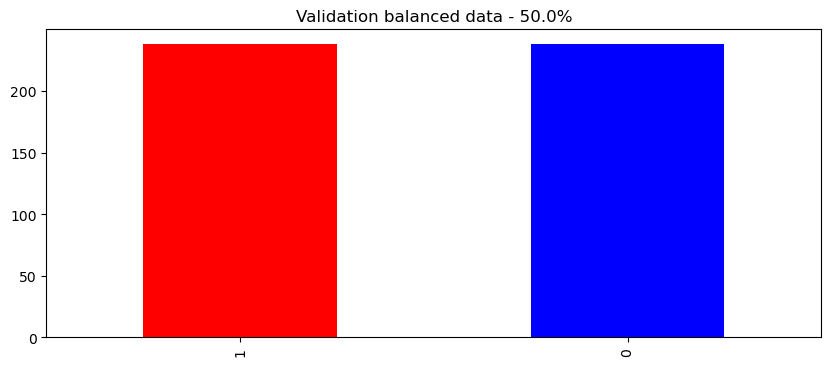

In [80]:
from sklearn.utils import shuffle

df_val_tmp = pd.DataFrame(y_val, columns=['target'])
 
index_goods = list(df_val_tmp[df_val_tmp['target']==0].index)
index_bads = list(df_val_tmp[df_val_tmp['target']==1].sample(len(index_goods)).index)
 
X_val_bal = X_val[index_goods + index_bads]
y_val_bal = y_val[index_goods + index_bads]

X_val_bal, y_val_bal = shuffle(X_val_bal, y_val_bal)
 
plt.figure(figsize=(10,4))
 
pd.DataFrame(y_val_bal)[0].value_counts().plot(kind='bar', color=['red','blue'])
plt.title(f'Validation balanced data - {100*round(sum(y_val_bal)/len(y_val_bal),3)}%')
 
plt.show()

In [23]:
BATCH_SIZE = 32 #this is default in keras, so it's no need to package
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

### Save splitted data 

In [25]:
"""Save splitted datasets"""

import h5py

with h5py.File('DataSet_Pneumonia', 'w') as f:
    dset = f.create_dataset("X_train", data=X_train)
    dset = f.create_dataset("y_train", data=y_train)
    
    dset = f.create_dataset("X_test", data=X_test)
    dset = f.create_dataset("y_test", data=y_test)
    
    dset = f.create_dataset("X_val_bla", data=X_val_bal)
    dset = f.create_dataset("y_val_bal", data=y_val_bal)

# Data augmentation

In [26]:
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"), # Applies horizontal flipping to a random 50% of the images
  layers.RandomRotation(0.1), # Rotates the input images by a random value in the range[–10%, +10%] (fraction of full circle [-36°, 36°])
  layers.RandomZoom(0.2), # Zooms in or out of the image by a random factor in the range [-20%, +20%]
])

# CNN from scratch
The dataset has relatively (around 5000) few traing samples, so overfitting is going  to be number one of concern.

## 1. First model
- 1 Dense layer with sigmoid function

In [27]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_raw = keras.Model(inputs=inputs, outputs=outputs)

In [28]:
model_raw.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                         

In [29]:
model_raw.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [30]:
history_raw = model_raw.fit(
  X_train, y_train,
  epochs=30,
  validation_data=(X_test, y_test))

Epoch 1/30


2023-01-21 13:19:44.061283: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


129/129 [==============================] - 113s 869ms/step - loss: 0.5755 - accuracy: 0.7878 - val_loss: 1.1983 - val_accuracy: 0.7486
Epoch 2/30
129/129 [==============================] - 110s 852ms/step - loss: 0.2531 - accuracy: 0.9066 - val_loss: 0.2358 - val_accuracy: 0.9340
Epoch 3/30
129/129 [==============================] - 120s 933ms/step - loss: 0.1944 - accuracy: 0.9317 - val_loss: 0.1578 - val_accuracy: 0.9431
Epoch 4/30
129/129 [==============================] - 112s 870ms/step - loss: 0.1523 - accuracy: 0.9419 - val_loss: 0.2072 - val_accuracy: 0.9272
Epoch 5/30
129/129 [==============================] - 120s 927ms/step - loss: 0.1348 - accuracy: 0.9527 - val_loss: 0.1646 - val_accuracy: 0.9420
Epoch 6/30
129/129 [==============================] - 124s 960ms/step - loss: 0.1168 - accuracy: 0.9546 - val_loss: 0.1408 - val_accuracy: 0.9522
Epoch 7/30
129/129 [==============================] - 129s 1s/step - loss: 0.1040 - accuracy: 0.9627 - val_loss: 0.1359 - val_accuracy:

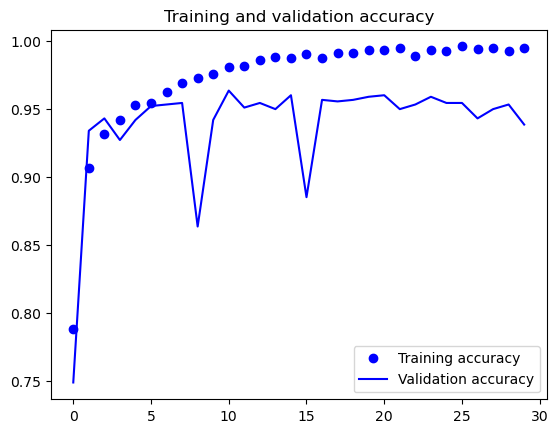

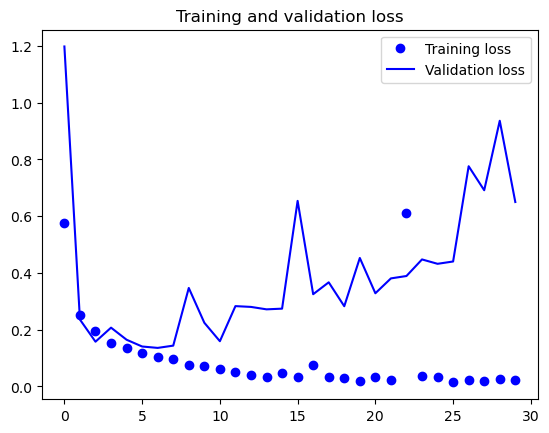

In [31]:
plot_loss_accurancy(history_raw)

15/15 [==============================] - 4s 235ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.9758    0.8487    0.9079       238
           1     0.8662    0.9790    0.9191       238

    accuracy                         0.9139       476
   macro avg     0.9210    0.9139    0.9135       476
weighted avg     0.9210    0.9139    0.9135       476



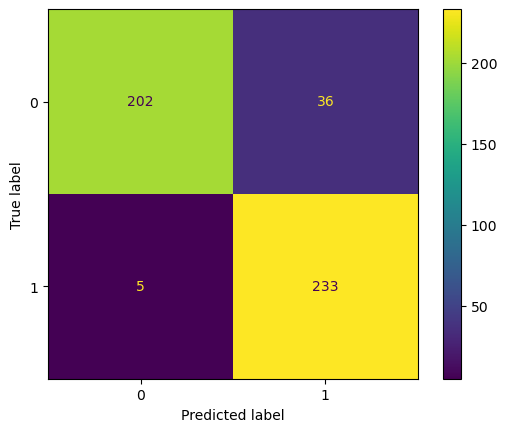

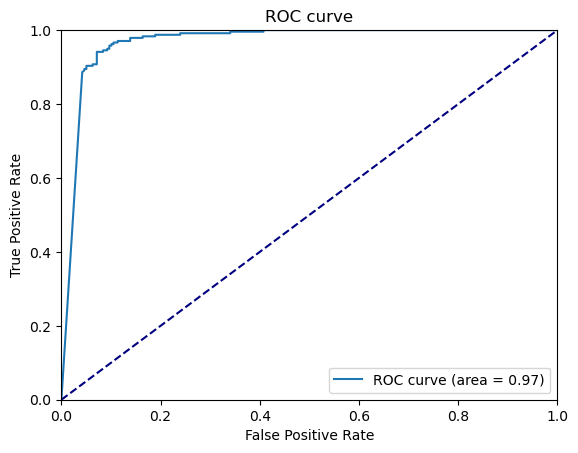

In [32]:
evaluate_model(model_raw)

The model has high accuracy, but it is The model is overfitted.

### Save the best model

In [33]:
dir_name = "/Users/marysia/Desktop/Deep learning/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
model_raw.save(os.path.join(dir_name, 'pneumonia_models'))

INFO:tensorflow:Assets written to: /Users/marysia/Desktop/Deep learning/models/pneumonia_models/assets


INFO:tensorflow:Assets written to: /Users/marysia/Desktop/Deep learning/models/pneumonia_models/assets


# 2. Raw model with dropout
To previous model I added the 1 Dropout layer and 1 dense layer with 256 hidden neurons to prevent overfitting.

In [34]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu') (x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_raw_pre = keras.Model(inputs=inputs, outputs=outputs)

In [35]:
model_raw_pre.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                       

In [36]:
model_raw_pre.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [38]:
history_raw_pre = model_raw_pre.fit(
  X_train, y_train,
  epochs=30,
  validation_data=(X_test, y_test))

Epoch 1/30
129/129 [==============================] - 136s 1s/step - loss: 0.0873 - accuracy: 0.9719 - val_loss: 0.1844 - val_accuracy: 0.9477
Epoch 2/30
129/129 [==============================] - 136s 1s/step - loss: 0.0837 - accuracy: 0.9754 - val_loss: 0.2230 - val_accuracy: 0.9545
Epoch 3/30
129/129 [==============================] - 138s 1s/step - loss: 0.0829 - accuracy: 0.9729 - val_loss: 0.1989 - val_accuracy: 0.9431
Epoch 4/30
129/129 [==============================] - 148s 1s/step - loss: 0.0627 - accuracy: 0.9783 - val_loss: 0.2552 - val_accuracy: 0.9625
Epoch 5/30
129/129 [==============================] - 164s 1s/step - loss: 0.0592 - accuracy: 0.9795 - val_loss: 0.2794 - val_accuracy: 0.9534
Epoch 6/30
129/129 [==============================] - 167s 1s/step - loss: 0.0468 - accuracy: 0.9827 - val_loss: 0.2170 - val_accuracy: 0.9579
Epoch 7/30
129/129 [==============================] - 141s 1s/step - loss: 0.0525 - accuracy: 0.9849 - val_loss: 0.3629 - val_accuracy: 0.9386

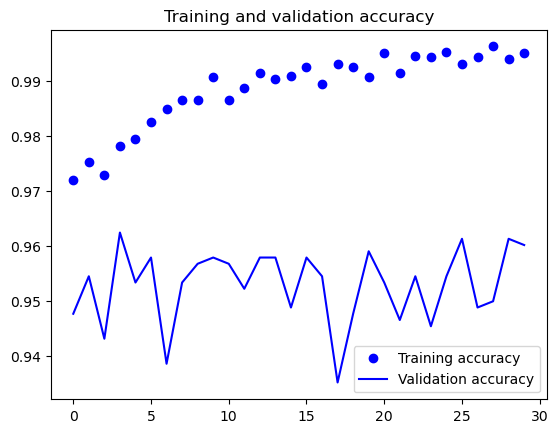

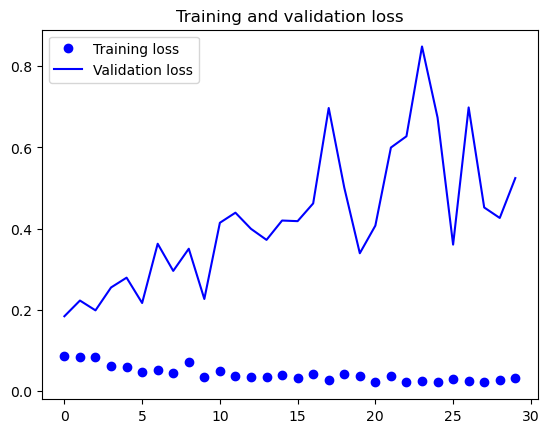

In [39]:
plot_loss_accurancy(history_raw_pre)

15/15 [==============================] - 4s 263ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.9563    0.9202    0.9379       238
           1     0.9231    0.9580    0.9402       238

    accuracy                         0.9391       476
   macro avg     0.9397    0.9391    0.9391       476
weighted avg     0.9397    0.9391    0.9391       476



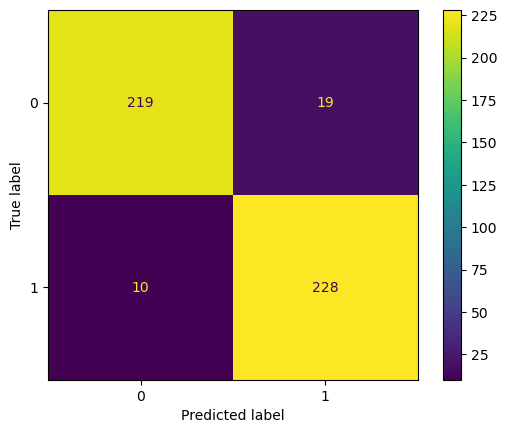

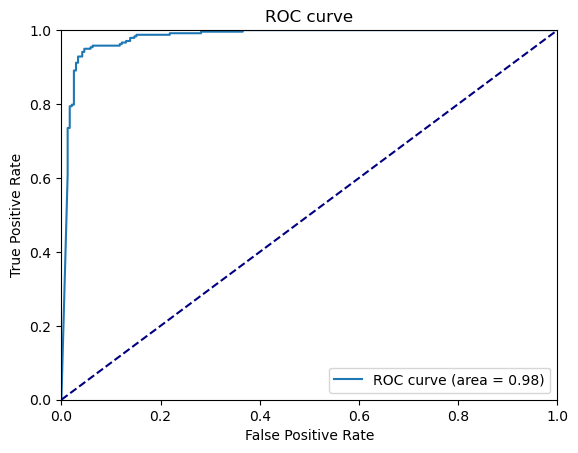

In [40]:
evaluate_model(model_raw_pre)

The model is still overfitted.

In [41]:
dir_name = "/Users/marysia/Desktop/Deep learning/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
model_raw_pre.save(os.path.join(dir_name, 'pneumonia_models'))

INFO:tensorflow:Assets written to: /Users/marysia/Desktop/Deep learning/models/pneumonia_models/assets


INFO:tensorflow:Assets written to: /Users/marysia/Desktop/Deep learning/models/pneumonia_models/assets


# 3. First model without overfitting using Early Stopping
- double CNN and then pooling
- in the following CNN decrease filter size (-2)
- exploit Early Stopping for prevent overfitting (if the parameter on the test set decreases for 3 epochs, the training of the model will stop)

In [42]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu') (x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_1 = keras.Model(inputs=inputs, outputs=outputs)


callback = EarlyStopping(monitor='val_loss', 
                         patience=3,
                         verbose=1)

In [43]:
model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                       

In [44]:
model_1.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [45]:
history_1 = model_1.fit(
  X_train, y_train,
  epochs=30,
  validation_data=(X_test, y_test),
  callbacks=[callback])

Epoch 1/30
129/129 [==============================] - 132s 1s/step - loss: 0.9473 - accuracy: 0.7717 - val_loss: 1.1097 - val_accuracy: 0.7315
Epoch 2/30
129/129 [==============================] - 133s 1s/step - loss: 0.4308 - accuracy: 0.8929 - val_loss: 0.1835 - val_accuracy: 0.9295
Epoch 3/30
129/129 [==============================] - 129s 1s/step - loss: 0.2276 - accuracy: 0.9192 - val_loss: 0.1523 - val_accuracy: 0.9386
Epoch 4/30
129/129 [==============================] - 131s 1s/step - loss: 0.1677 - accuracy: 0.9402 - val_loss: 0.1817 - val_accuracy: 0.9283
Epoch 5/30
129/129 [==============================] - 130s 1s/step - loss: 0.1480 - accuracy: 0.9436 - val_loss: 0.2438 - val_accuracy: 0.9363
Epoch 6/30
129/129 [==============================] - 123s 953ms/step - loss: 0.1881 - accuracy: 0.9510 - val_loss: 0.2763 - val_accuracy: 0.9124
Epoch 6: early stopping


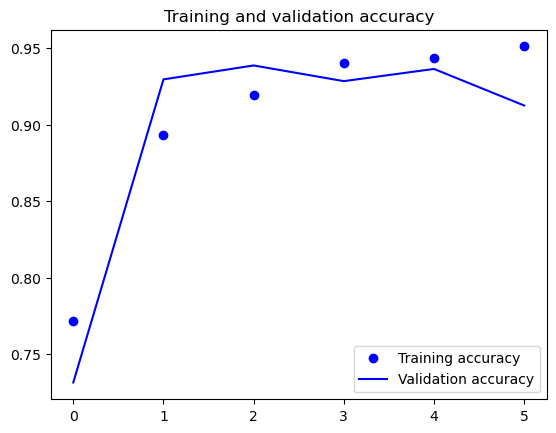

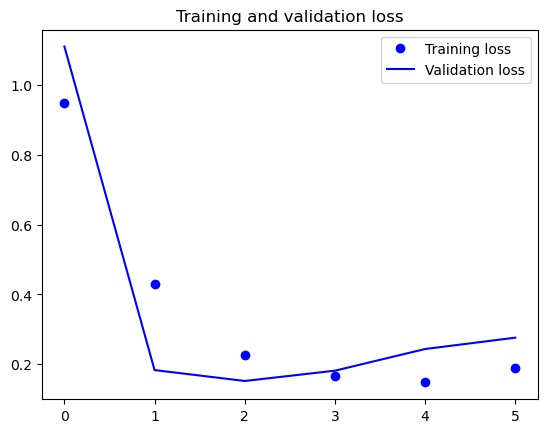

In [46]:
plot_loss_accurancy(history_1)

15/15 [==============================] - 4s 258ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.9040    0.9496    0.9262       238
           1     0.9469    0.8992    0.9224       238

    accuracy                         0.9244       476
   macro avg     0.9255    0.9244    0.9243       476
weighted avg     0.9255    0.9244    0.9243       476



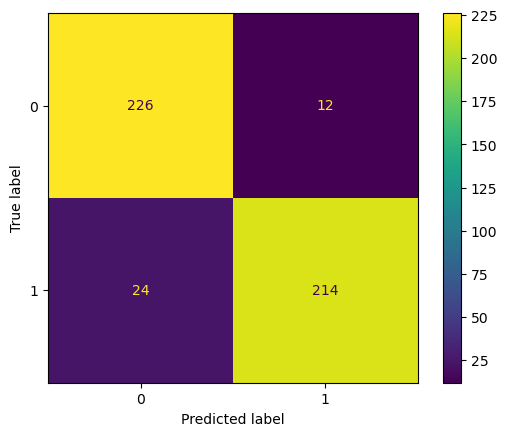

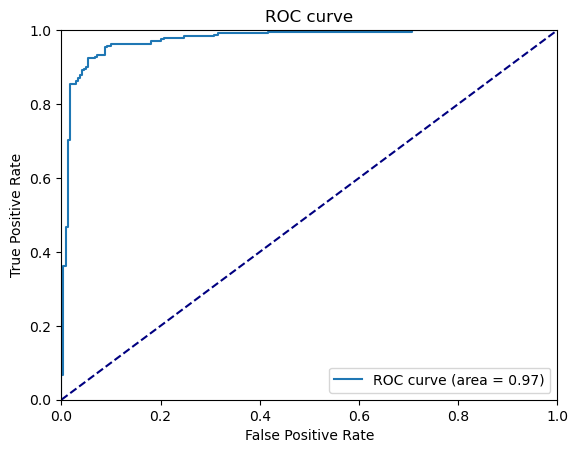

In [47]:
evaluate_model(model_1)

In [48]:
dir_name = "/Users/marysia/Desktop/Deep learning/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
model_1.save(os.path.join(dir_name, 'pneumonia_models'))

INFO:tensorflow:Assets written to: /Users/marysia/Desktop/Deep learning/models/pneumonia_models/assets


INFO:tensorflow:Assets written to: /Users/marysia/Desktop/Deep learning/models/pneumonia_models/assets


Early stopping prevent the overfitting, so I check if it possible to increase the accuracy.

# 4. Second model without overfitting
This model consist additional training data using data augmentation.
- 2 Dense layer
- 1 Dropout layer (for prevent overfitting)

In [49]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu') (x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model_2 = keras.Model(inputs=inputs, outputs=outputs)

model_2.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [50]:
model_2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 125, 125, 64)      18496     
                                                           

In [51]:
model_2.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [52]:
history_2 = model_2.fit(
  X_train, y_train,
  epochs=30,
  validation_data=(X_test, y_test))

Epoch 1/30


129/129 [==============================] - 129s 994ms/step - loss: 0.9643 - accuracy: 0.7277 - val_loss: 0.4519 - val_accuracy: 0.7986
Epoch 2/30
129/129 [==============================] - 128s 992ms/step - loss: 0.5042 - accuracy: 0.7797 - val_loss: 0.7906 - val_accuracy: 0.6052
Epoch 3/30
129/129 [==============================] - 125s 970ms/step - loss: 0.3888 - accuracy: 0.8407 - val_loss: 0.2986 - val_accuracy: 0.8680
Epoch 4/30
129/129 [==============================] - 124s 964ms/step - loss: 0.3271 - accuracy: 0.8695 - val_loss: 0.6713 - val_accuracy: 0.7440
Epoch 5/30
129/129 [==============================] - 127s 986ms/step - loss: 0.3221 - accuracy: 0.8800 - val_loss: 0.2245 - val_accuracy: 0.9044
Epoch 6/30
129/129 [==============================] - 124s 957ms/step - loss: 0.2626 - accuracy: 0.9031 - val_loss: 0.3714 - val_accuracy: 0.8532
Epoch 7/30
129/129 [==============================] - 127s 984ms/step - loss: 0.2544 - accuracy: 0.9080 - val_loss: 0.3369 - val_accura

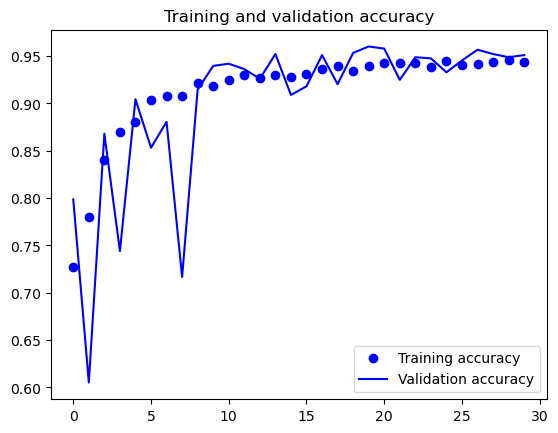

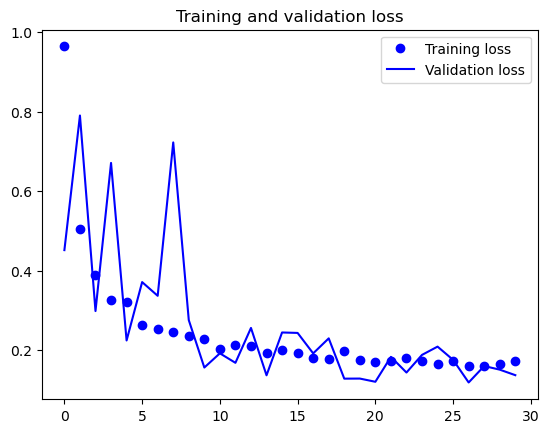

In [53]:
plot_loss_accurancy(history_2)

**Con:** There is no overfitting and the accurancy is 0.871, which is quite high.

15/15 [==============================] - 4s 237ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.9816    0.8950    0.9363       238
           1     0.9035    0.9832    0.9416       238

    accuracy                         0.9391       476
   macro avg     0.9425    0.9391    0.9390       476
weighted avg     0.9425    0.9391    0.9390       476



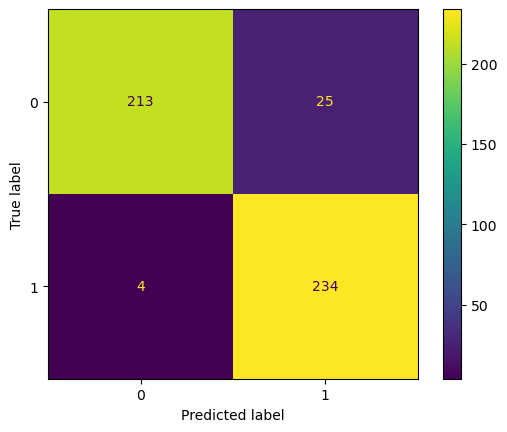

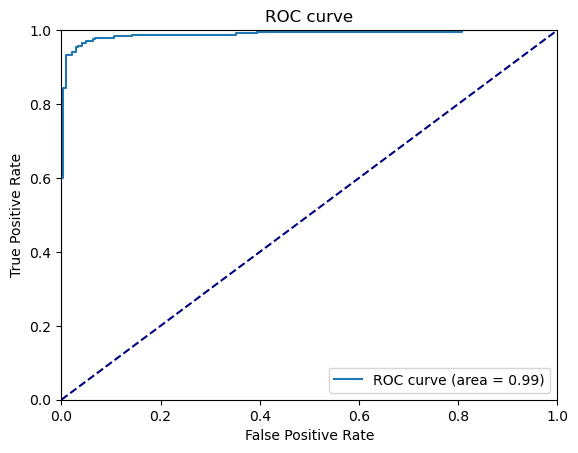

In [54]:
evaluate_model(model_2)

In [76]:
dir_name = "/Users/marysia/Desktop/Deep learning/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
model_2.save(os.path.join(dir_name, 'pneumonia_models'))

INFO:tensorflow:Assets written to: /Users/marysia/Desktop/Deep learning/models/pneumonia_models/assets


INFO:tensorflow:Assets written to: /Users/marysia/Desktop/Deep learning/models/pneumonia_models/assets


The accuarcy is higher than model with Early Stopping.

# 5. Third model without overfitting
2 dense layer, one with 128 hidden neuron
dropout and data agumentation

In [71]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)

x = layers.Dense(128, activation='relu') (x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model_3 = keras.Model(inputs=inputs, outputs=outputs)

model_3.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [72]:
model_3.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling_7 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_35 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 125, 125, 64)      18496     
                                                           

In [73]:
history_3 = model_3.fit(
  X_train, y_train,
  epochs=30,
  validation_data=(X_test, y_test))

Epoch 1/30


129/129 [==============================] - 288s 2s/step - loss: 1.0409 - accuracy: 0.7133 - val_loss: 1.2109 - val_accuracy: 0.7144
Epoch 2/30
129/129 [==============================] - 277s 2s/step - loss: 0.5075 - accuracy: 0.7717 - val_loss: 0.3490 - val_accuracy: 0.8521
Epoch 3/30
129/129 [==============================] - 273s 2s/step - loss: 0.3959 - accuracy: 0.8322 - val_loss: 0.5716 - val_accuracy: 0.6894
Epoch 4/30
129/129 [==============================] - 264s 2s/step - loss: 0.3574 - accuracy: 0.8600 - val_loss: 0.2185 - val_accuracy: 0.9192
Epoch 5/30
129/129 [==============================] - 263s 2s/step - loss: 0.2926 - accuracy: 0.8914 - val_loss: 0.2938 - val_accuracy: 0.8828
Epoch 6/30
129/129 [==============================] - 274s 2s/step - loss: 0.2829 - accuracy: 0.9051 - val_loss: 0.3319 - val_accuracy: 0.9010
Epoch 7/30
129/129 [==============================] - 267s 2s/step - loss: 0.2454 - accuracy: 0.9122 - val_loss: 0.1707 - val_accuracy: 0.9386
Epoch 8/30

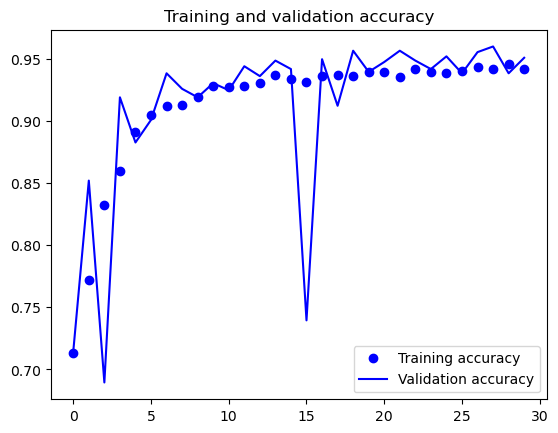

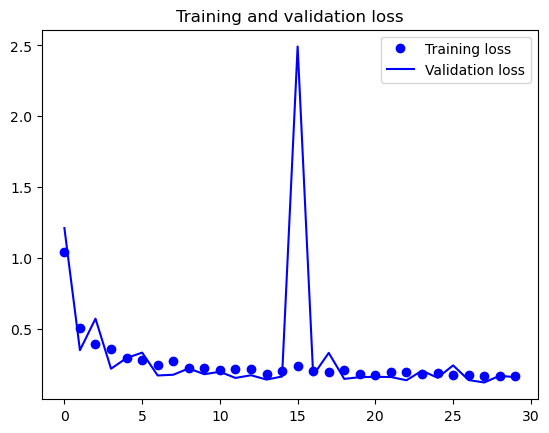

In [74]:
plot_loss_accurancy(history_3)

15/15 [==============================] - 8s 512ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.9598    0.9034    0.9307       238
           1     0.9087    0.9622    0.9347       238

    accuracy                         0.9328       476
   macro avg     0.9343    0.9328    0.9327       476
weighted avg     0.9343    0.9328    0.9327       476



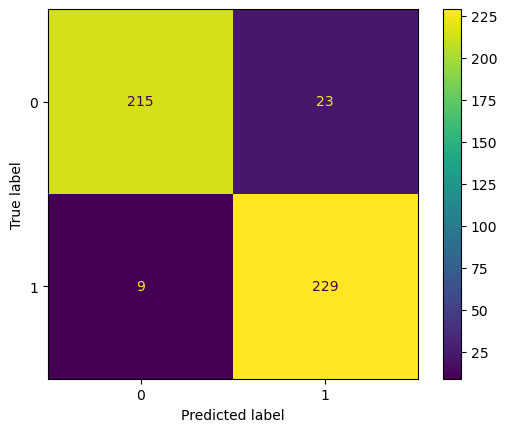

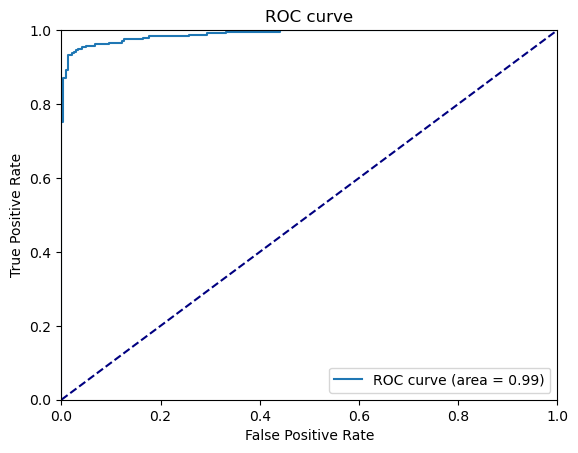

In [75]:
evaluate_model(model_3)

In [60]:
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
model_3.save(os.path.join(dir_name, 'pneumonia_models'))

INFO:tensorflow:Assets written to: /Users/marysia/Desktop/Deep learning/models/pneumonia_models/assets


INFO:tensorflow:Assets written to: /Users/marysia/Desktop/Deep learning/models/pneumonia_models/assets


# 6. Fourth model without overfitting

-3 Dense layers (two with 128 hidden neurons)

In [63]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)

x = layers.Dense(128, activation='relu') (x)
x = layers.Dense(128, activation='relu') (x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model_4 = keras.Model(inputs=inputs, outputs=outputs)

model_4.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [69]:
model_4.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 125, 125, 64)      18496     
                                                           

In [64]:
history_4 = model_4.fit(
  X_train, y_train,
  epochs=30,
  validation_data=(X_test, y_test))

Epoch 1/30


129/129 [==============================] - 247s 2s/step - loss: 0.6982 - accuracy: 0.7248 - val_loss: 3.5808 - val_accuracy: 0.7395
Epoch 2/30
129/129 [==============================] - 236s 2s/step - loss: 0.4663 - accuracy: 0.7870 - val_loss: 3.1286 - val_accuracy: 0.6928
Epoch 3/30
129/129 [==============================] - 237s 2s/step - loss: 0.3959 - accuracy: 0.8451 - val_loss: 4.0977 - val_accuracy: 0.7474
Epoch 4/30
129/129 [==============================] - 255s 2s/step - loss: 0.3444 - accuracy: 0.8673 - val_loss: 3.1843 - val_accuracy: 0.7395
Epoch 5/30
129/129 [==============================] - 262s 2s/step - loss: 0.3336 - accuracy: 0.8795 - val_loss: 1.1635 - val_accuracy: 0.7952
Epoch 6/30
129/129 [==============================] - 267s 2s/step - loss: 0.2848 - accuracy: 0.8927 - val_loss: 0.7397 - val_accuracy: 0.7668
Epoch 7/30
129/129 [==============================] - 264s 2s/step - loss: 0.2652 - accuracy: 0.9068 - val_loss: 1.5231 - val_accuracy: 0.7759
Epoch 8/30

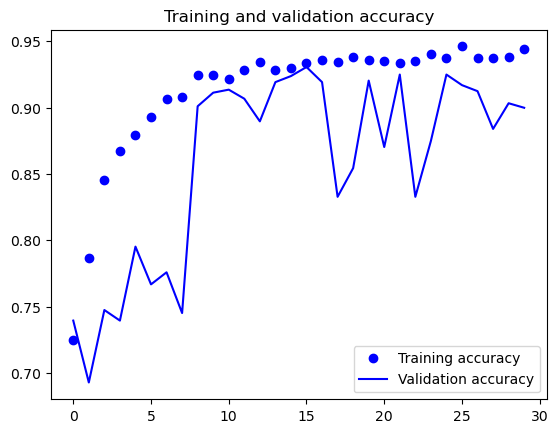

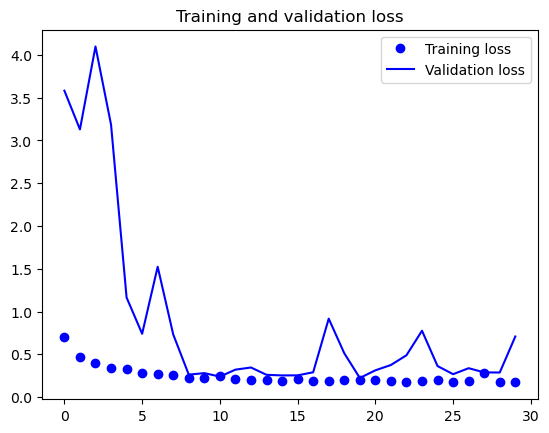

In [65]:
plot_loss_accurancy(history_4)

15/15 [==============================] - 9s 564ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.9553    0.7185    0.8201       238
           1     0.7744    0.9664    0.8598       238

    accuracy                         0.8424       476
   macro avg     0.8649    0.8424    0.8400       476
weighted avg     0.8649    0.8424    0.8400       476



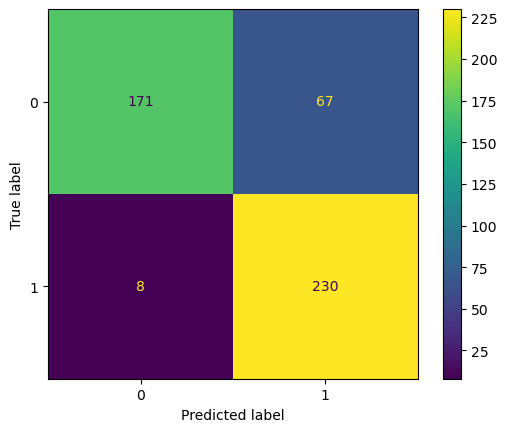

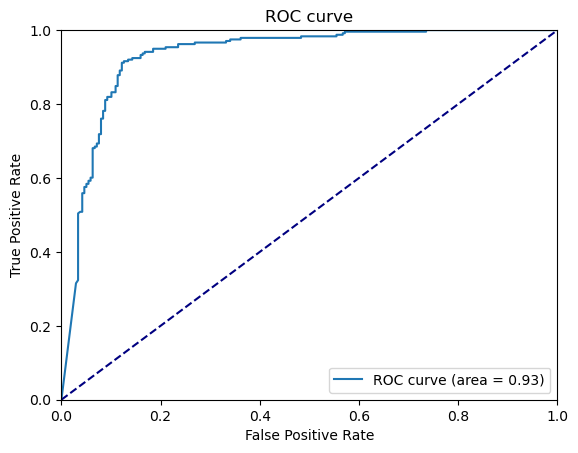

In [66]:
evaluate_model(model_4)

In [67]:
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
model_4.save(os.path.join(dir_name, 'pneumonia_models'))

INFO:tensorflow:Assets written to: /Users/marysia/Desktop/Deep learning/models/pneumonia_models/assets


INFO:tensorflow:Assets written to: /Users/marysia/Desktop/Deep learning/models/pneumonia_models/assets
